#**1. Time Series Analysis:**
#Explore historical trends and patterns in gold prices over the specified time period.
#Identify seasonality, cyclicality, and any discernible long-term trends in the gold market.


# 2. Advanced Modeling:
#  Develop predictive models to forecast future gold prices based on historical data.
# Evaluate and compare the performance of different forecasting algorithms.

# 3. Trading Strategy Development:
# Formulate and backtest trading strategies based on the provided price and volume information.
#Explore the feasibility of reverse trading strategies for profit maximization.

# 4. Market Sentiment Analysis:
# Investigate the impact of market events on gold prices.
# Assess market sentiment and its influence on short-term and long-term price movements.

# 5. Statistical Analysis:
# Conduct statistical tests and analyses to gain insights into the characteristics of gold price movements.
# Explore correlations with external factors and macroeconomic indicators.

        Unnamed: 0        Close         Volume         Open         High  \
count  2511.000000  2511.000000    2511.000000  2511.000000  2511.000000   
mean   1260.792911  1498.726085  185970.770609  1498.725528  1508.451454   
std     729.262879   298.824811   97600.769382   299.118187   301.262244   
min       0.000000  1049.600000       1.000000  1051.500000  1062.700000   
25%     630.500000  1249.850000  126693.500000  1249.500000  1257.300000   
50%    1259.000000  1332.800000  175421.000000  1334.000000  1342.400000   
75%    1888.500000  1805.850000  234832.000000  1805.600000  1815.450000   
max    2532.000000  2093.100000  787217.000000  2094.400000  2098.200000   

               Low  
count  2511.000000  
mean   1488.869932  
std     296.417703  
min    1045.400000  
25%    1242.350000  
50%    1326.600000  
75%    1793.050000  
max    2074.600000  


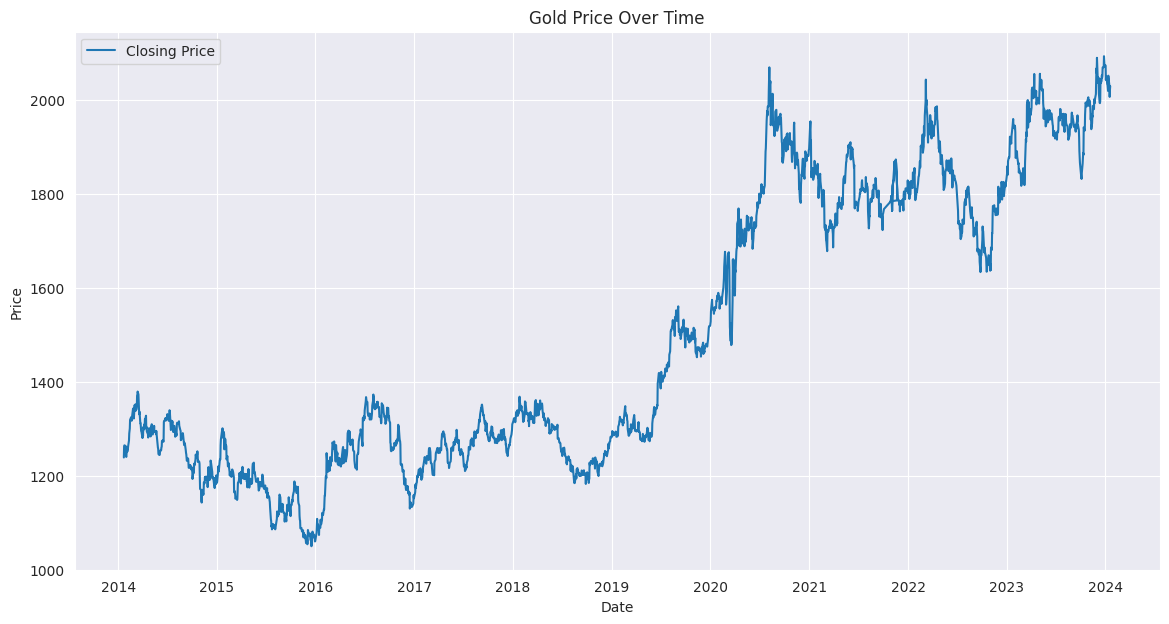

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
url = "https://raw.githubusercontent.com/79Aniket/Mentorness_Internship/main/goldstock.csv"
df = pd.read_csv(url)

# Data Preprocessing
df.fillna(method="ffill", inplace=True)
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

# Descriptive statistics
print(df.describe())

# Time series visualization
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Closing Price')
plt.title('Gold Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


# **Time Series Analysis and Modeling**

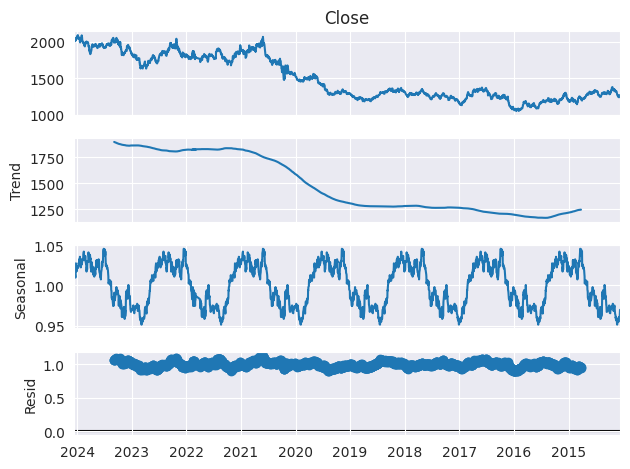

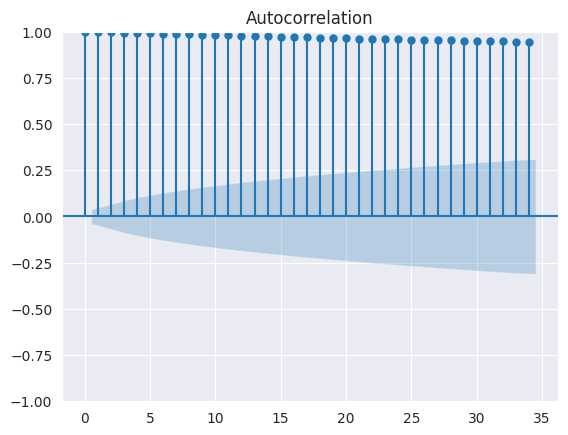

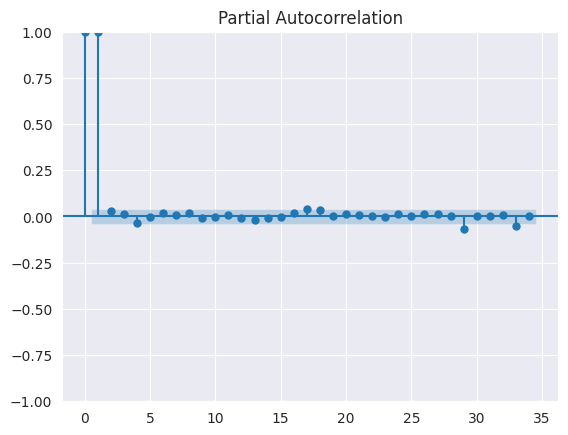

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

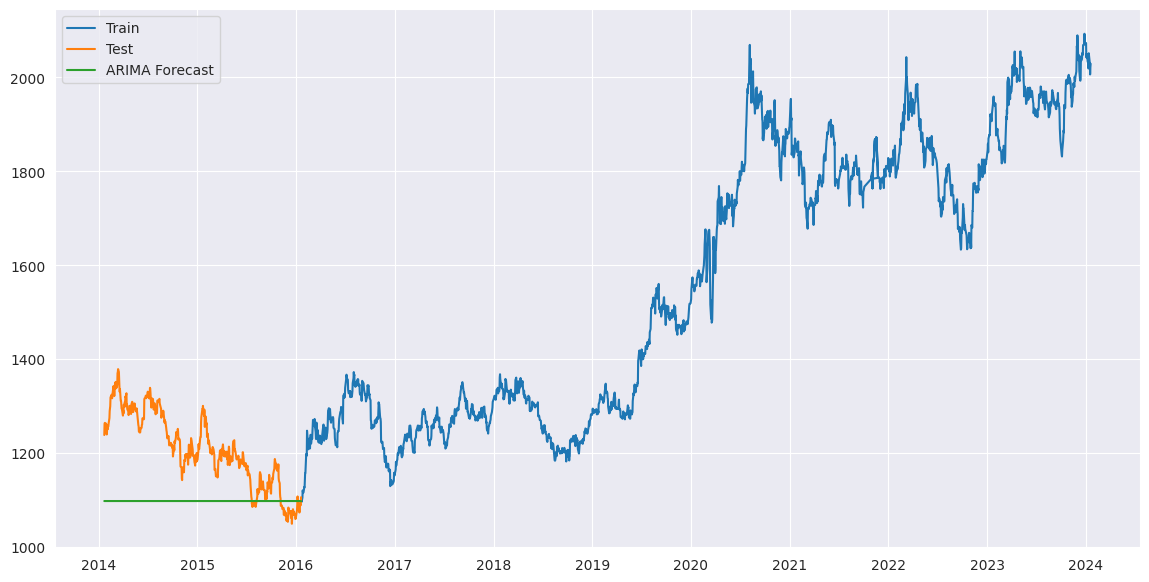

ARIMA RMSE: 135.8767871226694


In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Decompose the time series
result = seasonal_decompose(df['Close'], model='multiplicative', period=365)
result.plot()
plt.show()

# Plot autocorrelation and partial autocorrelation
plot_acf(df['Close'])
plt.show()
plot_pacf(df['Close'])
plt.show()

# Train-test split for ARIMA
train_size = int(len(df) * 0.8)
train, test = df['Close'][:train_size], df['Close'][train_size:]

# Fit ARIMA model
arima_model = ARIMA(train, order=(5, 1, 0))
arima_fit = arima_model.fit()

# Forecast
arima_forecast = arima_fit.forecast(steps=len(test))

# Plot ARIMA results
plt.figure(figsize=(14, 7))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.legend()
plt.show()

# Evaluate ARIMA model
arima_rmse = mean_squared_error(test, arima_forecast, squared=False)
print(f'ARIMA RMSE: {arima_rmse}')


# **LSTM Model for Prediction**

In [6]:
# Prepare data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

train_scaled = scaled_data[:train_size]
test_scaled = scaled_data[train_size:]

# Prepare the data for LSTM model
time_step = 100
X_train, Y_train = [], []
for i in range(time_step, len(train_scaled)):
    X_train.append(train_scaled[i - time_step:i, 0])
    Y_train.append(train_scaled[i, 0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_test, Y_test = [], []
for i in range(time_step, len(test_scaled)):
    X_test.append(test_scaled[i - time_step:i, 0])
    Y_test.append(test_scaled[i, 0])
X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train LSTM model
lstm_model.fit(X_train, Y_train, epochs=50, batch_size=64, verbose=1)

# Predict with LSTM model
train_predict = lstm_model.predict(X_train)
test_predict = lstm_model.predict(X_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
Y_train = scaler.inverse_transform([Y_train])
Y_test = scaler.inverse_transform([Y_test])



Epoch 1/50
30/30 [==============================] - 15s 241ms/step - loss: 0.0309
Epoch 2/50
30/30 [==============================] - 6s 210ms/step - loss: 0.0022
Epoch 3/50
30/30 [==============================] - 4s 134ms/step - loss: 0.0013
Epoch 4/50
30/30 [==============================] - 4s 122ms/step - loss: 0.0012
Epoch 5/50
30/30 [==============================] - 3s 105ms/step - loss: 0.0012
Epoch 6/50
30/30 [==============================] - 3s 105ms/step - loss: 0.0011
Epoch 7/50
30/30 [==============================] - 5s 152ms/step - loss: 0.0011
Epoch 8/50
30/30 [==============================] - 5s 157ms/step - loss: 0.0011
Epoch 9/50
30/30 [==============================] - 7s 233ms/step - loss: 9.9075e-04
Epoch 10/50
30/30 [==============================] - 6s 196ms/step - loss: 9.1546e-04
Epoch 11/50
30/30 [==============================] - 4s 136ms/step - loss: 8.7439e-04
Epoch 12/50
30/30 [==============================] - 6s 199ms/step - loss: 8.3852e-04
Epoch 13

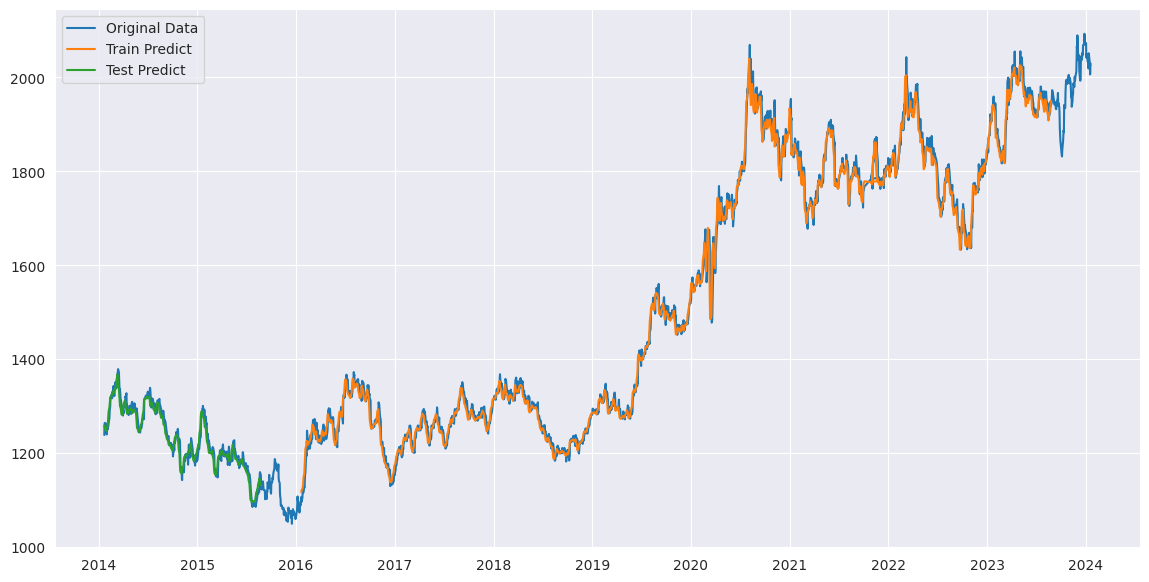

LSTM RMSE: 15.725709067534996


In [14]:
# Plot LSTM results
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Original Data')
plt.plot(df.index[time_step:time_step + len(train_predict)], train_predict, label='Train Predict')
plt.plot(df.index[train_size + time_step: train_size + time_step + len(test_predict)], test_predict, label='Test Predict') # Use train_size to calculate the starting index for test predictions
plt.legend()
plt.show()

# Evaluate LSTM model
lstm_rmse = mean_squared_error(Y_test[0], test_predict, squared=False)
print(f'LSTM RMSE: {lstm_rmse}')


# **Moving Average Strategy**

<ipython-input-15-7bd65bfe3ef4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Signal'][50:] = np.where(df['SMA50'][50:] > df['SMA200'][50:], 1, 0)


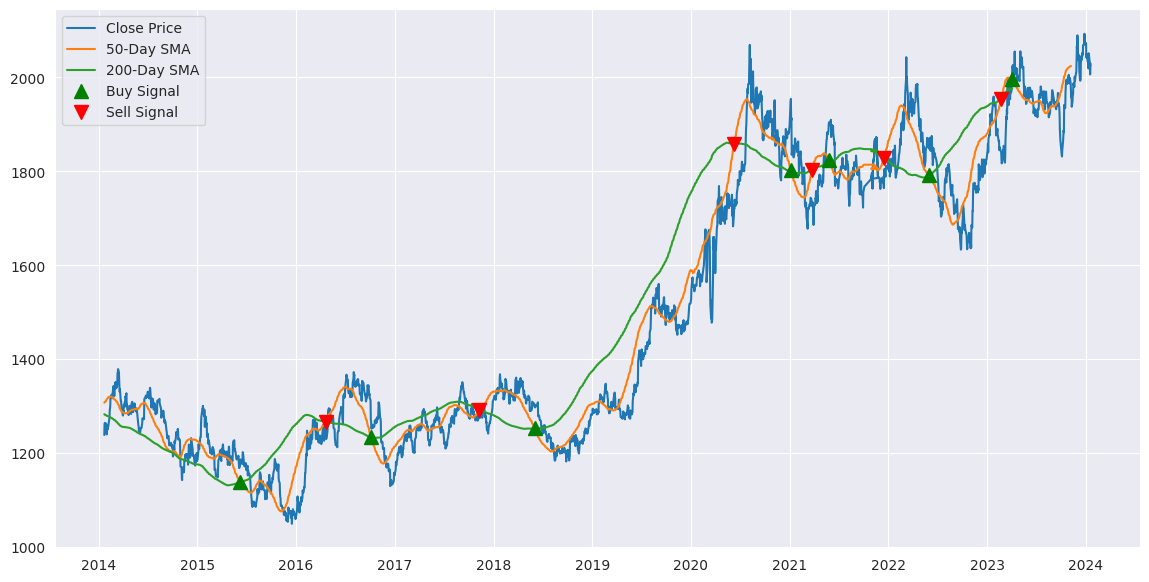

In [15]:
# Moving Average Strategy
df['SMA50'] = df['Close'].rolling(window=50).mean()
df['SMA200'] = df['Close'].rolling(window=200).mean()

# Trading signals
df['Signal'] = 0
df['Signal'][50:] = np.where(df['SMA50'][50:] > df['SMA200'][50:], 1, 0)
df['Position'] = df['Signal'].diff()

# Plot signals
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['SMA50'], label='50-Day SMA')
plt.plot(df['SMA200'], label='200-Day SMA')
plt.plot(df[df['Position'] == 1].index, df['SMA50'][df['Position'] == 1], '^', markersize=10, color='g', lw=0, label='Buy Signal')
plt.plot(df[df['Position'] == -1].index, df['SMA50'][df['Position'] == -1], 'v', markersize=10, color='r', lw=0, label='Sell Signal')
plt.legend()
plt.show()


# **Market Events and Sentiment Analysis**

In [19]:
# Simulate market events data
events_data = {
    'Date': pd.to_datetime(['2020-01-15', '2020-03-11', '2020-06-30', '2020-09-21', '2020-12-15']),
    'Event': [
        'Trade Deal Signed',
        'COVID-19 Declared Pandemic',
        'Economic Stimulus Announced',
        'Stock Market Crash',
        'Vaccine Approval'
    ]
}

events_df = pd.DataFrame(events_data)

# Simulate sentiment scores (random for illustration purposes)
np.random.seed(42)
events_df['Sentiment_Score'] = np.random.uniform(-1, 1, events_df.shape[0])

print(events_df)

        Date                        Event  Sentiment_Score
0 2020-01-15            Trade Deal Signed        -0.250920
1 2020-03-11   COVID-19 Declared Pandemic         0.901429
2 2020-06-30  Economic Stimulus Announced         0.463988
3 2020-09-21           Stock Market Crash         0.197317
4 2020-12-15             Vaccine Approval        -0.687963



Price movements around the event: Trade Deal Signed
Date
2020-01-17    1558.8
2020-01-16    1550.5
2020-01-15    1554.0
2020-01-14    1544.6
2020-01-13    1550.6
2020-01-10    1557.5
Name: Close, dtype: float64

Price movements around the event: COVID-19 Declared Pandemic
Date
2020-03-16    1486.5
2020-03-13    1516.7
2020-03-12    1590.3
2020-03-11    1642.3
2020-03-10    1659.1
2020-03-09    1675.7
2020-03-06    1672.4
Name: Close, dtype: float64

Price movements around the event: Economic Stimulus Announced
Date
2020-07-02    1790.0
2020-07-01    1779.9
2020-06-30    1800.5
2020-06-29    1781.2
2020-06-26    1780.3
2020-06-25    1770.6
Name: Close, dtype: float64

Price movements around the event: Stock Market Crash
Date
2020-09-25    1866.3
2020-09-24    1876.9
2020-09-23    1868.4
2020-09-22    1907.6
2020-09-21    1910.6
2020-09-18    1962.1
2020-09-17    1949.9
2020-09-16    1970.5
Name: Close, dtype: float64

Price movements around the event: Vaccine Approval
Date
2020-12-18  

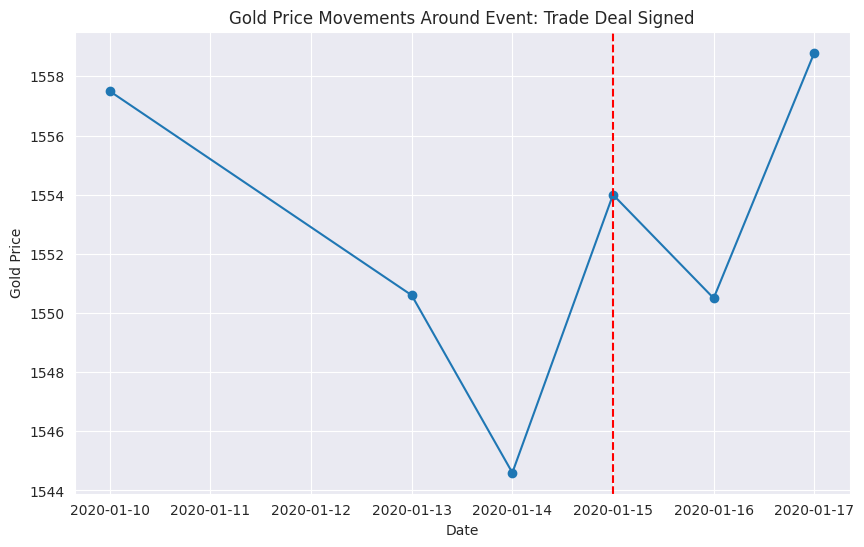

In [20]:
# Analyze gold price movements around event dates
def get_price_movement_around_event(date, window=5):
    start_date = date - pd.Timedelta(days=window)
    end_date = date + pd.Timedelta(days=window)
    # Ensure the date range exists within the DataFrame index
    price_movement = df.loc[(df.index >= start_date) & (df.index <= end_date), 'Close']
    return price_movement

price_movements = {}
for _, row in events_df.iterrows():
    event_date = row['Date']
    event_desc = row['Event']
    price_movements[event_desc] = get_price_movement_around_event(event_date)

for event, prices in price_movements.items():
    print(f"\nPrice movements around the event: {event}")
    print(prices)

# Plot price movements around the first event as an example
example_event = list(price_movements.keys())[0]
example_prices = price_movements[example_event]

plt.figure(figsize=(10, 6))
plt.plot(example_prices.index, example_prices.values, marker='o', linestyle='-')
plt.axvline(x=events_df.loc[events_df['Event'] == example_event, 'Date'].values[0], color='r', linestyle='--')
plt.title(f'Gold Price Movements Around Event: {example_event}')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.grid(True)
plt.show()


In [23]:
# Calculate correlation between sentiment scores and gold price changes
price_changes = df['Close'].pct_change()

# 'Date' is likely already the index, so reset it to a column
events_df = events_df.reset_index()

# Merge sentiment data with gold price changes
merged_df = df[['Close']].join(events_df.set_index('Date')[['Sentiment_Score']], how='inner')
merged_df['Price_Change'] = merged_df['Close'].pct_change()

# Calculate correlation
correlation = merged_df[['Sentiment_Score', 'Price_Change']].corr()
print("Correlation between sentiment scores and gold price changes:\n", correlation)

# Short-term and long-term impact assessment using Granger causality test
from statsmodels.tsa.stattools import grangercausalitytests

# Fill missing values in 'Sentiment_Score' with zeros
merged_df['Sentiment_Score'].fillna(0, inplace=True)

# Adjust max_lag based on the available data
max_lag = 1  # Set a lower max_lag value

# Perform Granger causality test
# Note: This might still give a warning if the data is insufficient,
# but it will attempt to run the test with the adjusted lag.
test_result = grangercausalitytests(merged_df[['Close', 'Sentiment_Score']], max_lag, verbose=True)

Correlation between sentiment scores and gold price changes:
                  Sentiment_Score  Price_Change
Sentiment_Score         1.000000      0.816078
Price_Change            0.816078      1.000000

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0430  , p=0.3886  , df_denom=1, df_num=1
ssr based chi2 test:   chi2=8.1719  , p=0.0043  , df=1
likelihood ratio test: chi2=4.4513  , p=0.0349  , df=1
parameter F test:         F=2.0430  , p=0.3886  , df_denom=1, df_num=1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


# **Descriptive Statistics**

In [24]:
# Descriptive statistics
descriptive_stats = df.describe()
print(descriptive_stats)


        Unnamed: 0        Close         Volume         Open         High  \
count  2511.000000  2511.000000    2511.000000  2511.000000  2511.000000   
mean   1260.792911  1498.726085  185970.770609  1498.725528  1508.451454   
std     729.262879   298.824811   97600.769382   299.118187   301.262244   
min       0.000000  1049.600000       1.000000  1051.500000  1062.700000   
25%     630.500000  1249.850000  126693.500000  1249.500000  1257.300000   
50%    1259.000000  1332.800000  175421.000000  1334.000000  1342.400000   
75%    1888.500000  1805.850000  234832.000000  1805.600000  1815.450000   
max    2532.000000  2093.100000  787217.000000  2094.400000  2098.200000   

               Low        SMA50       SMA200       Signal     Position  
count  2511.000000  2462.000000  2312.000000  2511.000000  2510.000000  
mean   1488.869932  1495.400811  1486.643820     0.372760     0.000398  
std     296.417703   293.724673   282.339355     0.483635     0.071980  
min    1045.400000  107

# Statistical Tests

In [25]:
from statsmodels.tsa.stattools import adfuller
from scipy.stats import jarque_bera

# Augmented Dickey-Fuller test for stationarity
adf_test = adfuller(df['Close'])
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])

# Jarque-Bera test for normality
jb_test = jarque_bera(df['Close'])
print("Jarque-Bera Statistic:", jb_test[0])
print("p-value:", jb_test[1])


ADF Statistic: -1.7172755789704768
p-value: 0.4222342775667287
Jarque-Bera Statistic: 282.1807582831075
p-value: 5.311618675316005e-62


# Correlation Analysis

In [26]:
# Simulate macroeconomic indicators data
np.random.seed(42)
df['Interest_Rate'] = np.random.uniform(0, 5, df.shape[0])
df['Inflation_Rate'] = np.random.uniform(-1, 10, df.shape[0])
df['Stock_Index'] = np.random.uniform(1000, 5000, df.shape[0])

# Correlation matrix
correlation_matrix = df[['Close', 'Interest_Rate', 'Inflation_Rate', 'Stock_Index']].corr()
print(correlation_matrix)


                   Close  Interest_Rate  Inflation_Rate  Stock_Index
Close           1.000000      -0.014164        0.006452     0.008731
Interest_Rate  -0.014164       1.000000        0.008186    -0.001345
Inflation_Rate  0.006452       0.008186        1.000000     0.006351
Stock_Index     0.008731      -0.001345        0.006351     1.000000


# Regression Analysis

In [27]:
import statsmodels.api as sm

# Define the independent variables (macroeconomic indicators)
X = df[['Interest_Rate', 'Inflation_Rate', 'Stock_Index']]
X = sm.add_constant(X)  # Add a constant term for the intercept

# Define the dependent variable (gold prices)
y = df['Close']

# Perform regression analysis
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2666
Date:                Mon, 24 Jun 2024   Prob (F-statistic):              0.850
Time:                        13:01:49   Log-Likelihood:                -17874.
No. Observations:                2511   AIC:                         3.576e+04
Df Residuals:                    2507   BIC:                         3.578e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1496.5895     21.099     70.

Complete Code